In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm

In [89]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_size)
        self.logvar = nn.Linear(128, latent_size)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return  z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [1, 28, 28]
            nn.Sigmoid()
        )
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, z):
        return self.decode(z)

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
        self.latent_size = latent_size
    
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        return self.decoder(z), mu, logvar
    
    def get_latent_size(self):
        return self.latent_size
      
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [90]:
# Training the VAE
latent_dim = 2
beta = 1.0
vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# DataLoader for MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# classes to use 
classes = [0, 1]

# Filter the dataset to only include the selected classes
indices = [i for i, label in enumerate(train_data.targets) if label in classes]
filtered_train_data = Subset(train_data, indices)

train_loader = DataLoader(filtered_train_data, batch_size=128, shuffle=True, drop_last=True)

# Training loop
# vae.train()
# epochs = 10
# losses = []
# for epoch in range(epochs):
#     total_loss = 0
#     for x, _ in train_loader:
#         # x_viewed = x.view(-1, 28 * 28) 
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae(x)
#         loss = loss_function(x_recon, x, mu, logvar, beta)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     losses.append(total_loss/len(train_data))
#     print(f"Epoch {epoch + 1}, Loss: {total_loss/len(train_data):.2f}")

In [91]:
# Save the model
# torch.save(vae.state_dict(), './models/vae_3_latent_dim_2_classes_0_1_best.pth')

# # Plot the loss
# plt.plot(losses)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()

In [92]:
# Used trained model
vae.load_state_dict(torch.load('./models/vae_3_latent_dim_2_classes_0_1_best.pth'))
# Visualizing the latent space
vae.eval()
latents, labels, var = [], [], []
with torch.no_grad():
    for x, y in train_loader:
        _, mu, logvar = vae(x)
        latents.append(mu)
        labels.append(y)
        var.append(torch.exp(0.5 * logvar))
latents = torch.cat(latents)
labels = torch.cat(labels)
var = torch.cat(var)

if latent_dim > 2:
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    latents_tsne = tsne.fit_transform(latents)

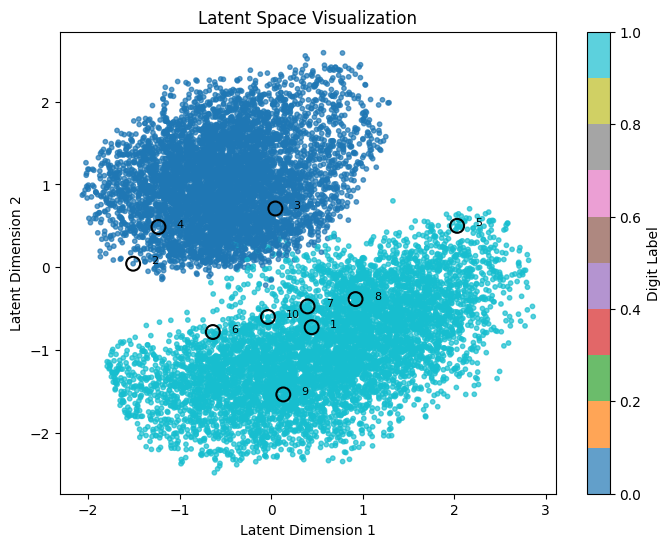

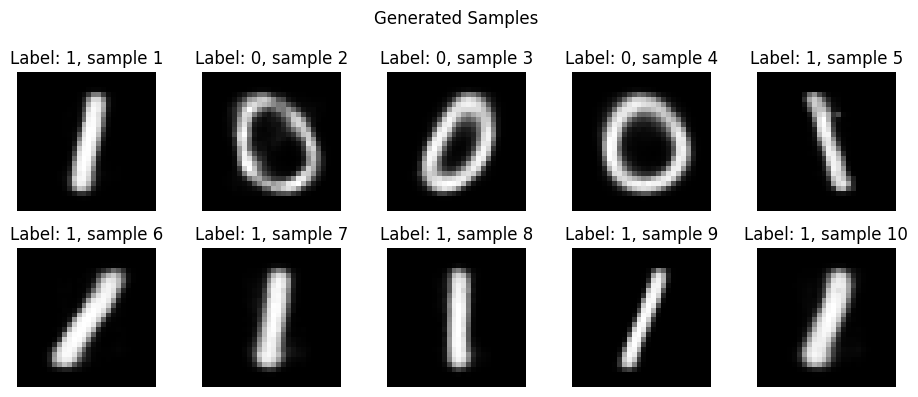

In [93]:
decoder = vae.decoder
n_samples = 10
sample_indices = torch.randint(0, len(latents), (n_samples,))
sample_latents = torch.Tensor(latents[sample_indices])
sample_labels = labels[sample_indices]
with torch.no_grad():
    generated = decoder(sample_latents)
    generated = generated.view(-1, 28, 28).numpy()
cmap_binary = matplotlib.colors.ListedColormap(['blue', 'red'])
# Projection on the 2D latent space or if latent_dim = 2, plot the latent space
if latent_dim > 2:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=labels, cmap=cmap_binary, alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Latent Space')
else :
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')

# Entourer les points échantillonnés
if latent_dim > 2:
    for idx, (x, y) in enumerate(latents_tsne[sample_indices]):
        plt.scatter(x, y, edgecolor='black', facecolor='none', s=100, linewidth=1.5) 
        plt.text(x + 2, y, f'{idx+1}', color='black', fontsize=8) 
else:
    for idx, (x, y) in enumerate(sample_latents[:, :2]):
        plt.scatter(x, y, edgecolor='black', facecolor='none', s=100, linewidth=1.5)  # Cercle rouge
        plt.text(x + 0.2, y, f'{idx+1}', color='black', fontsize=8)  # Annoter avec un index

plt.show()

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'Label: {sample_labels[i].item()}, sample {i + 1}')
    plt.suptitle('Generated Samples')
plt.show()

### ENSURING PROPER GEOMETRY THROUGH MEANINGFUL VARIANCE FUNCTIONS

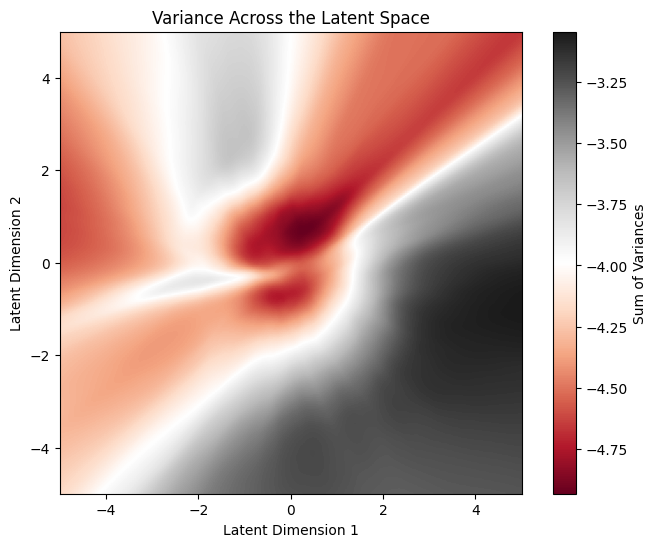

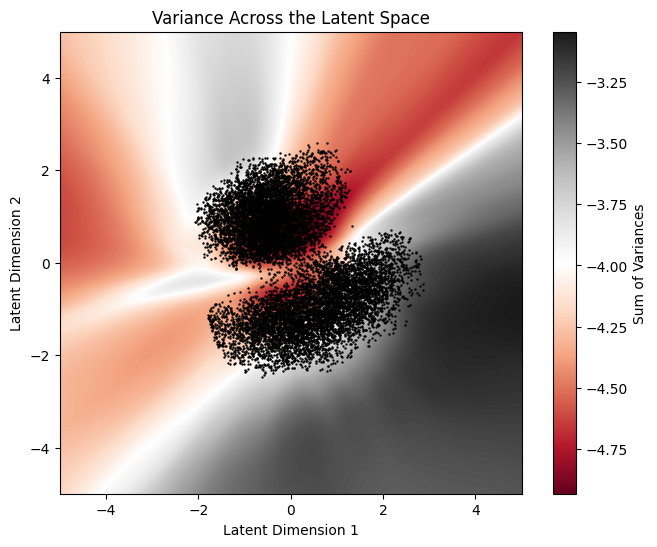

In [94]:
# t-SNE of the variance
if latent_dim == 2:
    
    grid_range = 5  # Cover latent space in [-3, 3] for each dimension
    grid_resolution = 200  # Number of points per axis

    # Generate a grid of points in the latent space
    x = np.linspace(-grid_range, grid_range, grid_resolution)
    y = np.linspace(-grid_range, grid_range, grid_resolution)
    grid_x, grid_y = np.meshgrid(x, y)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)  # Shape: (grid_resolution^2, 2)

    # Convert grid points to a tensor
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Pass grid points through the decoder to reconstruct data
    vae.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        reconstructed_data = vae.decoder(grid_points_tensor)  # Shape: (grid_resolution^2, input_dim)

    # Pass the reconstructed data through the encoder to compute mu and logvar
    with torch.no_grad():
        _, mu, logvar = vae.encoder(reconstructed_data)  # Encoder maps reconstructed data back to latent space
        variance = torch.exp(logvar)  # Convert logvar to variance

    # Compute the sum of variances across latent dimensions
    variance_sum = variance.sum(dim=-1).numpy()

    # Reshape variance_sum to match the grid shape
    variance_sum_grid = variance_sum.reshape(grid_resolution, grid_resolution)

    # Plot the variance as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        np.log(variance_sum_grid),
        extent=[-grid_range, grid_range, -grid_range, grid_range],
        origin='lower',
        cmap='RdGy',
    )
    plt.colorbar(label='Sum of Variances')

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Variance Across the Latent Space')
    plt.show()
    # Plot the variance as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        np.log(variance_sum_grid),
        extent=[-grid_range, grid_range, -grid_range, grid_range],
        origin='lower',
        cmap='RdGy',
    )
    plt.colorbar(label='Sum of Variances')

    plt.scatter(latents[:, 0], latents[:, 1], c='black', s=0.5, label='Training Data')

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Variance Across the Latent Space')
    plt.show()
else:
    
     # Compute log(sum_j(sigma_j(z))) for color mapping
    summed_var = [torch.sum(v).item() for v in var]  # Summing variances
    log_summed_var = torch.log(torch.tensor(summed_var))  # Logarithm of summed variances

    # Plot t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        latents_tsne[:, 0], latents_tsne[:, 1], 
        c=log_summed_var, cmap='RdGy', alpha=0.7, s=10
    )
    plt.colorbar(scatter, label='Log(Sum of Variances)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Latent Space with Variance Color Map')
    plt.show()

The variance far from the data (in black) are pretty arbitrary values

Now, we will use an external network that will learn the variance sigma in order to set it far from the data. This will make it easier all the geometry onto the latent space

In [95]:
class RBFNetwork(nn.Module):
    def __init__(self, centers, bandwidths, latent_dim):
        super(RBFNetwork, self).__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32), requires_grad=False)  # Fixed centers
        self.bandwidths = nn.Parameter(torch.tensor(bandwidths, dtype=torch.float32), requires_grad=False)  # Fixed bandwidths
        self.weights = nn.Parameter(torch.ones(centers.shape[0], latent_dim))  # Learnable weights
        self.epsilon = 1e-6  # Small constant to avoid division by zero

    def forward(self, z):
        # Compute RBF activations
        distances = torch.cdist(z, self.centers) ** 2  # Squared distances
        activations = torch.exp(-self.bandwidths.unsqueeze(0) * distances)
        
        # Compute precision
        precision = activations @ self.weights + self.epsilon
        return 1 / precision  # Convert precision to variance


In [96]:
from sklearn.cluster import KMeans
# Encode training data to latent space
vae.eval()
z_train, sigma2_train = [], []
with torch.no_grad():
    for x, _ in train_loader:
        _, mu, logvar = vae.encoder(x)
        z_train.append(mu)
        sigma2_train.append(torch.exp(logvar))

z_train = torch.cat(z_train).numpy()  # Latent representations
sigma2_train = torch.cat(sigma2_train).numpy()  # Variance estimates

# Perform k-means to find RBF centers
K = 32  # Number of RBF centers used in the paper
kmeans = KMeans(n_clusters=K, random_state=0).fit(z_train)
centers = kmeans.cluster_centers_  # RBF centers
labels_kmean = kmeans.labels_

# Compute bandwidths
a = 1.0  # Hyperparameter for RBF sharpness used in the paper
bandwidths = []
for k in range(K):
    cluster_points = z_train[labels_kmean == k]
    if len(cluster_points) > 0:
        bandwidth = 0.5* (a / len(cluster_points) * np.sum(np.linalg.norm(cluster_points - centers[k], axis=1)))**-2
    else:
        bandwidth = 1.0  # Fallback for empty clusters
    bandwidths.append(bandwidth)

bandwidths = np.array(bandwidths)

# Initialize the RBF network
latent_dim = z_train.shape[1]
rbf_net = RBFNetwork(centers, bandwidths, latent_dim)

# Train the RBF network
optimizer = torch.optim.Adam(rbf_net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

z_train_tensor = torch.tensor(z_train, dtype=torch.float32)
sigma2_train_tensor = torch.tensor(sigma2_train, dtype=torch.float32)

for epoch in range(1001):  # Training loop
    optimizer.zero_grad()
    predicted_variance = rbf_net(z_train_tensor)
    loss = criterion(predicted_variance, sigma2_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 6.270975112915039
Epoch 100, Loss: 5.225933074951172
Epoch 200, Loss: 4.504032611846924
Epoch 300, Loss: 3.972839593887329
Epoch 400, Loss: 3.562983989715576
Epoch 500, Loss: 3.235558032989502
Epoch 600, Loss: 2.9669251441955566
Epoch 700, Loss: 2.741838216781616
Epoch 800, Loss: 2.549992561340332
Epoch 900, Loss: 2.384152889251709
Epoch 1000, Loss: 2.2390804290771484


torch.Size([40000, 2])


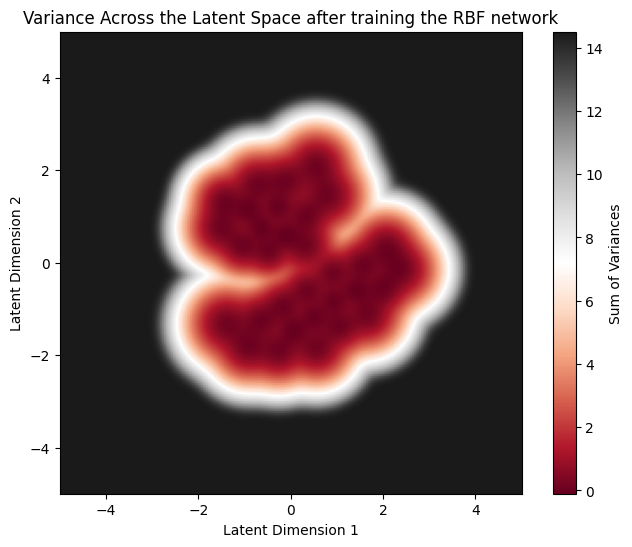

In [97]:
grid_range = 5  # Cover latent space in [-3, 3] for each dimension
grid_resolution = 200  # Number of points per axis

# Generate a grid of points in the latent space
x = np.linspace(-grid_range, grid_range, grid_resolution)
y = np.linspace(-grid_range, grid_range, grid_resolution)
grid_x, grid_y = np.meshgrid(x, y)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)  # Shape: (grid_resolution^2, 2)

# Convert grid points to a tensor
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
print(grid_points_tensor.shape)
# Pass grid points through the RBF network to compute variance
with torch.no_grad():
    predicted_variance = rbf_net(grid_points_tensor).numpy()

predicted_variance_sum = np.sum(predicted_variance, axis=-1)
# Reshape predicted_variance to match the grid shape
predicted_variance_sum_grid = predicted_variance_sum.reshape(grid_resolution, grid_resolution)

# Plot the variance as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    np.log(predicted_variance_sum_grid),
    extent=[-grid_range, grid_range, -grid_range, grid_range],
    origin='lower',
    cmap='RdGy',
)
plt.colorbar(label='Sum of Variances')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Variance Across the Latent Space after training the RBF network')
plt.show()

#### Let us add this trained network to the main VAE (Optional for the moment)

In [98]:
# class Encoder_RBF(nn.Module):
#     def __init__(self, latent_size, RBF_Network):
#         super(Encoder_RBF, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 7, 7]
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(64 * 7 * 7, 128),
#             nn.ReLU()
#         )
#         self.mu = nn.Linear(128, latent_size)
#         self.RBF_Network = RBF_Network

#     def encode(self, x):
#         x = self.encoder(x)
#         mu = self.mu(x)
#         with torch.no_grad():
#             var = self.RBF_Network(mu)
#         return mu, var

#     def reparameterize(self, mu, var):
#         std = torch.sqrt(var)
#         eps = torch.randn_like(std)
#         return mu + eps * std
    
#     def forward(self, x):
#         mu, var = self.encode(x)
#         z = self.reparameterize(mu, var)
#         return  z, mu, var
    
# class VAE_RBF(nn.Module):
#     def __init__(self, latent_size, RBF_Network):
#         super(VAE_RBF, self).__init__()
#         self.encoder = Encoder_RBF(latent_size, RBF_Network)
#         self.decoder = Decoder(latent_size)
    
#     def forward(self, x):
#         z, mu, var = self.encoder(x)
#         return self.decoder(z), mu, var
    
# def loss_function_vae_rbf(recon_x, x, mu, var, beta=1.0):
#     BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     KLD = -0.5 * beta * torch.sum(1 + torch.log(var) - mu.pow(2) - logvar.exp())
#     return BCE + KLD

In [99]:
# vae_rbf = VAE_RBF(latent_dim, rbf_net)

# # Training the VAE with RBF
# vae_rbf.train()
# optimizer = optim.Adam(vae_rbf.parameters(), lr=1e-3)

# epochs = 10
# losses = []
# for epoch in range(epochs):
#     total_loss = 0
#     for x, _ in train_loader:
#         # x_viewed = x.view(-1, 28 * 28) 
#         optimizer.zero_grad()
#         x_recon, mu, var = vae_rbf(x)
#         loss = loss_function_vae_rbf(x_recon, x, mu, var, beta)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     losses.append(total_loss/len(train_data))
#     print(f"Epoch {epoch + 1}, Loss: {total_loss/len(train_data):.2f}")

#### Let us work on our new space 

Go from 2D (t-SNE) observation space to the real latent space

In [100]:
def compute_jacobian_mu_sigma(vae, rbf_net, z):
    """
    Compute the Jacobian matrices for mu and sigma with respect to the latent space.

    Args:
        vae: Trained VAE model
        z: ILatent variable
        latent_dim: Dimensionality of the latent space

    Returns:
        J_mu, J_sigma: Jacobians of mu and sigma
    """
    # Get mu and log_var from the encoder
    z = z.requires_grad_(True)  # Enable gradients for input
    # Initialize Jacobians
    J_mu = torch.autograd.functional.jacobian(lambda x: vae.encoder(vae.decoder(x))[1], z)

    J_sigma = torch.autograd.functional.jacobian(lambda x: rbf_net(x), z)
    # Reshape
    J_mu = J_mu.squeeze(0).squeeze(1)
    J_sigma = J_sigma.squeeze(0).squeeze(1)
    return J_mu, J_sigma

def M_z(vae, rbf_net, z) -> torch.Tensor:
    """ 
    Compute the Riemannian metric for a point z.

    Args:
        vae: Trained VAE model
        rbf_net: RBF Network trained on the vae model for the variance
        z: Latent variable

    Returns:
        M_z: Riemannian matrix for the metric"""
    
    if len(z.shape) == 1:
        z = z.unsqueeze(0)
    # if z.shape[-1] != vae.get_latent_dim():
    #     raise ValueError('z should be size (batch_size, latent_dim).')
    
    vae.eval()
    rbf_net.eval()
    # Compute J_mu and J_sigma
    J_mu_z, J_sigma_z = compute_jacobian_mu_sigma(vae, rbf_net, z)

    M_z = J_mu_z.T @ J_mu_z + J_sigma_z.T @ J_sigma_z

    return M_z


In [101]:
# grid_range = 5  # Cover latent space in [-3, 3] for each dimension
# grid_resolution = 200  # Number of points per axis

# # Visualizing the distortion of the latent space
# x = np.linspace(-grid_range, grid_range, grid_resolution)
# y = np.linspace(-grid_range, grid_range, grid_resolution)
# grid_x, grid_y = np.meshgrid(x, y)
# grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)

# # Convert grid points to a tensor
# grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)

# distortion = []
# for z in tqdm(grid_points_tensor):
#     z = z.unsqueeze(0)
#     M_zz = M_z(vae, rbf_net, z)
#     distortion.append(torch.sqrt(torch.det(M_zz)))

# distortion_np = np.array(distortion)
# distortion_grid = np.reshape(distortion_np,(grid_resolution, grid_resolution))
# # Plot the variance as a heatmap
# plt.figure(figsize=(8, 6))
# plt.imshow(
#     distortion_grid,
#     extent=[-grid_range, grid_range, -grid_range, grid_range],
#     origin='lower',
#     cmap='RdGy',
# )
# plt.colorbar(label='Sum of Variances')

# plt.xlabel('Latent Dimension 1')
# plt.ylabel('Latent Dimension 2')
# plt.title('Variance Across the Latent Space after training the RBF network')
# plt.show()

In [102]:
# from scipy.optimize import minimize

# # Geodesic length functional
# def geodesic_length(gamma, m_z):
#     gamma = gamma.reshape(-1, latent_dim)  # Path as series of points
#     length = 0
#     for i in range(len(gamma) - 1):
#         z0, z1 = gamma[i], gamma[i + 1]
#         dz = z1 - z0
#         M = m_z(z0)
#         length += torch.sqrt(dz.T @ M @ dz + 1e-8)  # Add epsilon for numerical stability
#     print(length.item())
#     return length.item()

# # Optimize the path
# def optimize_geodesic(z0, z1, m_z, num_points=100):
#     # Initial path as straight line
#     gamma_init = torch.stack([
#         torch.linspace(z0[i], z1[i], num_points, dtype=torch.float32)
#         for i in range(len(z0))
#     ], dim=-1).flatten()
    
#     def objective(gamma):
#         gamma_tensor = torch.tensor(gamma, dtype=torch.float32, requires_grad=True)
#         return geodesic_length(gamma_tensor, m_z)
    
#     result = minimize(objective, gamma_init.detach().numpy(), method="BFGS", callback=lambda gamma:print(gamma))
#     optimized_path = result.x.reshape(-1, latent_dim)
#     geodesic_len = geodesic_length(torch.tensor(result.x).float(), m_z)

#     return optimized_path, geodesic_len


This method is an optimization problem in $\mathbb{R}^2$ so it is not optimized, let us solve numericaly the ODE $\gamma$ is solution of :

In [103]:
def compute_partial_M(vae, rbf_net, gamma_t):
    """Compute the partial derivatives of the metric tensor with respect to gamma_t."""
    d = gamma_t.shape[0]
    partial_M = []
    for j in range(d):
        gamma_t = gamma_t.clone().detach().requires_grad_(True)  # Enable gradients for gamma_t
        M_gamma_t = M_z(vae, rbf_net, gamma_t)
        print(gamma_t)

        # Compute the gradient of each element of M_gamma_t w.r.t. gamma_t[j]
        grad_M_j = torch.autograd.grad(
            M_gamma_t, gamma_t, create_graph=True, retain_graph=True
        )[0][j]
        
        partial_M.append(grad_M_j)
    
    return torch.stack(partial_M)

In [104]:
from scipy.integrate import solve_ivp

def d_M_z(vae, rbf_net, gamma):
    """
    Compute the derivative of the vectorized metric tensor with respect to gamma.
    Returns a (d^2, d) matrix representing partial derivatives.
    """    
    gamma = gamma.requires_grad_(True)
    print(gamma)
    dM_vec = torch.autograd.functional.jacobian(lambda x:M_z(vae, rbf_net, x), gamma)
    return dM_vec

# Define the geodesic ODE
def geodesic_ode(t, y, vae, rbf_net):
    """
    ODE system for the geodesic equations.
    y = [gamma, gamma_dot], where gamma is the position and gamma_dot is the velocity.
    """
    d = y.shape[-1] // 2
    gamma = torch.Tensor(y[:d])
    gamma_dot = torch.Tensor(y[d:])

    M = M_z(vae, rbf_net, gamma)
    dM_vec = d_M_z(vae, rbf_net, gamma)
    print(dM_vec)
    # Compute the terms of the ODE
    gamma_dot_kron = torch.kron(gamma_dot, gamma_dot)
    term1 = 2 * (gamma_dot @ dM_vec) @ gamma_dot.unsqueeze(-1)
    print(dM_vec.T)
    term2 = torch.matmul(dM_vec.T, gamma_dot_kron.unsqueeze(-1))
    rhs = -0.5 * torch.linalg.solve(M, (term1 - term2).squeeze(-1))

    return torch.cat([gamma_dot, rhs], dim=-1)

# Solve using solve_ivp
def solve_geodesic(z0, z1, vae, rbf_net, t_span=[0, 1], t_eval=None):
    # Initial conditions: gamma(0) = z0, gamma'(0) = some guess
    d = len(z0)
    initial_velocity_guess = (z1 - z0)  # Linear interpolation guess
    y0 = torch.cat([z0, initial_velocity_guess])
    sol = solve_ivp(
        geodesic_ode, t_span, y0, t_eval=t_eval, args=(vae, rbf_net), method='RK45'
    )
    
    return sol

In [105]:
def get_two_points_with_different_labels(latents, labels):
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if label1 != label2:
                return i, j

# Get indices of two points with different labels
idx1, idx2 = get_two_points_with_different_labels(latents, labels)

point1 = latents[idx1]
point2 = latents[idx2]
label1 = labels[idx1]
label2 = labels[idx2]

t = torch.linspace(0, 1, 100)
print(point1.shape)
solution = solve_geodesic(point1, point2, vae, rbf_net)

torch.Size([2])
tensor([0.9792, 0.0745], requires_grad=True)
tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 2] but got: [2, 4].

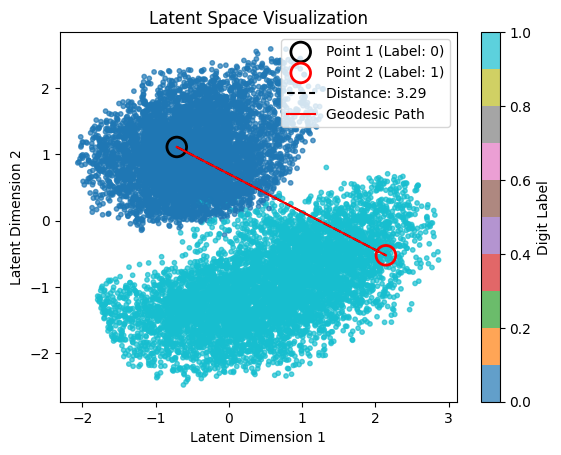

In [ ]:
euclidean_distance = torch.norm(point1 - point2).item()
# print(length_opt)
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')

# Get the coordinates of the selected points directly
point1_2d = point1[:2].numpy()
point2_2d = point2[:2].numpy()

# Highlight the two selected points
plt.scatter(point1_2d[0], point1_2d[1], edgecolor='black', facecolor='none', s=200, linewidth=2, label=f'Point 1 (Label: {label1})')
plt.scatter(point2_2d[0], point2_2d[1], edgecolor='red', facecolor='none', s=200, linewidth=2, label=f'Point 2 (Label: {label2})')

# Draw the path between the two points and annotate the Euclidean distance
plt.plot([point1_2d[0], point2_2d[0]], [point1_2d[1], point2_2d[1]], 'k--', linewidth=1.5, label=f'Distance: {euclidean_distance:.2f}')
plt.plot(solution[:, 0], solution[:, 1], label="Geodesic Path", color="red")
plt.legend()

plt.show()

ValueError: 'c' argument has 960000 elements, which is inconsistent with 'x' and 'y' with size 60000.

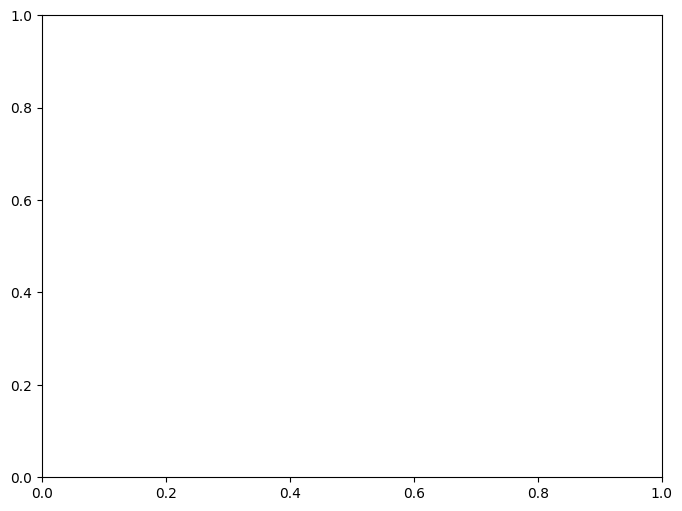

In [ ]:
# Visualize distortions in t-SNE space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=distortion, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Distortion (sqrt(det(J^T J)))')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization with Distortion')
plt.show()